In [16]:
import datetime
import numpy as np
import pandas_datareader as pdr
import esig
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import base
from utils import tosig
from utils.leadlag import leadlag
from rough_bergomi import rough_bergomi

from importlib import reload
import cvae_keras
reload(cvae_keras)

import matplotlib.pyplot as plt

## Data processing

In [17]:
# # S&P 500
# data = pdr.get_data_yahoo("^GSPC", datetime.date(2000, 1, 1), datetime.date(2019, 1, 1))["Close"]
# windows = []
# for _, window in data.resample('M'):
#     values = window.values
#     path = leadlag(values)
#     windows.append(path)

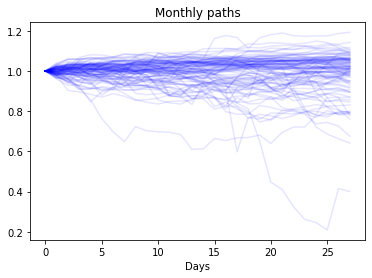

In [18]:
# Actually for rough_bergomi model, conditional VAE does no help because the cond are independent

# rough_bergomi
params = {
            "M": 100,
            "H": 0.14,
            "rho": -0.85,
            "xi0": 0.1,
            "nu": 1.5,
            "S0": 1.
          }

def _load_rough_bergomi(params, test_use = False):
    grid_points_dict = {"M": 28, "W": 5, "Y": 252}
    grid_points = grid_points_dict['M']
    params["T"] = grid_points / grid_points_dict["Y"]
    paths = rough_bergomi(grid_points, **params)
    if test_use:
        windows = paths
    else:   
        windows = [leadlag(path) for path in paths]
    return windows

windows = _load_rough_bergomi(params)

for path in windows:
    returns = path[::2, 1] / path[0, 1]
    plt.plot(returns, "b", alpha=0.1)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

## Log-signature computing

In [19]:
order = 4
def _logsig(path):
    return esig.tosig.stream2logsig(path, order)
def _sig(path):
    return esig.tosig.stream2sig(path, order)
orig_logsig = np.array([_logsig(path) for path in tqdm(windows, desc="Computing log-signatures")])
orig_sig = np.array([_sig(path) for path in tqdm(windows, desc="Computing signatures")])
scaler = MinMaxScaler(feature_range=(0.00001, 0.99999))
logsig = scaler.fit_transform(orig_logsig)
logsigs = logsig[1:]   # 1 week forecasting 1 week 
conditions = logsig[:-1] 

## CAVE

In [20]:
generator = cvae_keras.CVAE(n_latent=8, n_hidden = 50, alpha=0.003)
generator.build(logsigs.shape[-1], conditions.shape[-1])
generator.train(logsigs, conditions, n_epochs=10000)

Epoch 1/10000
1/1 [==============================] - 0s 316us/step - loss: 1.7583
Epoch 2/10000
1/1 [==============================] - 0s 964us/step - loss: 1.6477
Epoch 3/10000
1/1 [==============================] - 0s 959us/step - loss: 1.6527
Epoch 4/10000
1/1 [==============================] - 0s 1ms/step - loss: 1.5882
Epoch 5/10000
1/1 [==============================] - 0s 0s/step - loss: 1.5385
Epoch 6/10000
1/1 [==============================] - 0s 1ms/step - loss: 1.5021
Epoch 7/10000
1/1 [==============================] - 0s 997us/step - loss: 1.4671
Epoch 8/10000
1/1 [==============================] - 0s 0s/step - loss: 1.4486
Epoch 9/10000
1/1 [==============================] - 0s 998us/step - loss: 1.3834
Epoch 10/10000
1/1 [==============================] - 0s 996us/step - loss: 1.3386
Epoch 11/10000
1/1 [==============================] - 0s 2ms/step - loss: 1.3097
Epoch 12/10000
1/1 [==============================] - 0s 997us/step - loss: 1.2652
Epoch 13/10000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.1017
Epoch 199/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0851
Epoch 200/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0963
Epoch 201/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1004
Epoch 202/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0895
Epoch 203/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0954
Epoch 204/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0950
Epoch 205/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0930
Epoch 206/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0890
Epoch 207/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0831
Epoch 208/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0945
Epoch 209/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0911
Epoch 210/10000
1/

1/1 [==============================] - 0s 997us/step - loss: 0.0513
Epoch 297/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0527
Epoch 298/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0530
Epoch 299/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0509
Epoch 300/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0495
Epoch 301/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0500
Epoch 302/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0498
Epoch 303/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0517
Epoch 304/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0532
Epoch 305/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0503
Epoch 306/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0484
Epoch 307/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0496
Epoch 308/10000
1/1 

1/1 [==============================] - 0s 996us/step - loss: 0.0340
Epoch 493/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0343
Epoch 494/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0354
Epoch 495/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0336
Epoch 496/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0366
Epoch 497/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0361
Epoch 498/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0347
Epoch 499/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0337
Epoch 500/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0346
Epoch 501/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0346
Epoch 502/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0326
Epoch 503/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0359
Epoch 504/10000


1/1 [==============================] - 0s 2ms/step - loss: 0.0308
Epoch 689/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0278
Epoch 690/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0291
Epoch 691/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0275
Epoch 692/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0275
Epoch 693/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0267
Epoch 694/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0275
Epoch 695/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0257
Epoch 696/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0285
Epoch 697/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0272
Epoch 698/10000
1/1 [==============================] - 0s 995us/step - loss: 0.0286
Epoch 699/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0277
Epoch 700/10

1/1 [==============================] - 0s 997us/step - loss: 0.0221
Epoch 885/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0218
Epoch 886/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0254
Epoch 887/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0242
Epoch 888/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0259
Epoch 889/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0233
Epoch 890/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0221
Epoch 891/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0216
Epoch 892/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0242
Epoch 893/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0245
Epoch 894/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0238
Epoch 895/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0240
Epoch 896/

1/1 [==============================] - 0s 2ms/step - loss: 0.0220
Epoch 983/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0221
Epoch 984/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0229
Epoch 985/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0205
Epoch 986/10000
1/1 [==============================] - 0s 992us/step - loss: 0.0211
Epoch 987/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0221
Epoch 988/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0217
Epoch 989/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0209
Epoch 990/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0228
Epoch 991/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0226
Epoch 992/10000
1/1 [==============================] - 0s 995us/step - loss: 0.0198
Epoch 993/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0219
Epoch 994/10000


1/1 [==============================] - 0s 997us/step - loss: 0.0191
Epoch 1177/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0190
Epoch 1178/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 1179/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0198
Epoch 1180/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0208
Epoch 1181/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0189
Epoch 1182/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0227
Epoch 1183/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0194
Epoch 1184/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0189
Epoch 1185/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0198
Epoch 1186/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0193
Epoch 1187/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0197
Epoc

1/1 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 1371/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0184
Epoch 1372/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0185
Epoch 1373/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0198
Epoch 1374/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0189
Epoch 1375/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0203
Epoch 1376/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0180
Epoch 1377/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 1378/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 1379/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 1380/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 1381/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0187
Epoch 1382/1000

1/1 [==============================] - 0s 997us/step - loss: 0.0168
Epoch 1565/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0168
Epoch 1566/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0174
Epoch 1567/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 1568/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0184
Epoch 1569/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 1570/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0168
Epoch 1571/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0175
Epoch 1572/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0175
Epoch 1573/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0174
Epoch 1574/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 1575/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0164
Epo

1/1 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 1759/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0159
Epoch 1760/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 1761/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 1762/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0159
Epoch 1763/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0163
Epoch 1764/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0166
Epoch 1765/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0165
Epoch 1766/10000
1/1 [==============================] - 0s 1000us/step - loss: 0.0171
Epoch 1767/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 1768/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0174
Epoch 1769/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0170
Epoc

1/1 [==============================] - 0s 996us/step - loss: 0.0157
Epoch 1953/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0155
Epoch 1954/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 1955/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0178
Epoch 1956/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0163
Epoch 1957/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0165
Epoch 1958/10000
1/1 [==============================] - 0s 995us/step - loss: 0.0174
Epoch 1959/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0158
Epoch 1960/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0168
Epoch 1961/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 1962/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0160
Epoch 1963/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0160
E

1/1 [==============================] - 0s 998us/step - loss: 0.0162
Epoch 2147/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0155
Epoch 2148/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 2149/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0154
Epoch 2150/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0163
Epoch 2151/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0157
Epoch 2152/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 2153/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 2154/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0157
Epoch 2155/10000
1/1 [==============================] - 0s 994us/step - loss: 0.0165
Epoch 2156/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0156
Epoch 2157/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0146
Epo

Epoch 2243/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0154
Epoch 2244/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0151
Epoch 2245/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 2246/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0160
Epoch 2247/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 2248/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0158
Epoch 2249/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 2250/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0164
Epoch 2251/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0157
Epoch 2252/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 2253/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 2254/10000
1/1 [==============================] - 0s 998us/step - los

1/1 [==============================] - 0s 996us/step - loss: 0.0144
Epoch 2437/10000
1/1 [==============================] - 0s 992us/step - loss: 0.0156
Epoch 2438/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0158
Epoch 2439/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0147
Epoch 2440/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0158
Epoch 2441/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0147
Epoch 2442/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0162
Epoch 2443/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0152
Epoch 2444/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0153
Epoch 2445/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0150
Epoch 2446/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0153
Epoch 2447/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0140
Ep

Epoch 2533/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0154
Epoch 2534/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0145
Epoch 2535/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0151
Epoch 2536/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0153
Epoch 2537/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0154
Epoch 2538/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0148
Epoch 2539/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 2540/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0143
Epoch 2541/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0150
Epoch 2542/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0149
Epoch 2543/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 2544/10000
1/1 [==============================] - 0s 0s/step - 

1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 2631/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0143
Epoch 2632/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0146
Epoch 2633/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 2634/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0151
Epoch 2635/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0145
Epoch 2636/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0144
Epoch 2637/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 2638/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0147
Epoch 2639/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0152
Epoch 2640/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 2641/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 264

1/1 [==============================] - 0s 997us/step - loss: 0.0147
Epoch 2825/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0138
Epoch 2826/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0138
Epoch 2827/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0144
Epoch 2828/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0131
Epoch 2829/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0141
Epoch 2830/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0138
Epoch 2831/10000
1/1 [==============================] - 0s 992us/step - loss: 0.0146
Epoch 2832/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0136
Epoch 2833/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0138
Epoch 2834/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 2835/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0142

1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 3019/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0140
Epoch 3020/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0135
Epoch 3021/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0142
Epoch 3022/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0128
Epoch 3023/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0137
Epoch 3024/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0138
Epoch 3025/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0138
Epoch 3026/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0144
Epoch 3027/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0141
Epoch 3028/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0133
Epoch 3029/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0141
Ep

1/1 [==============================] - 0s 996us/step - loss: 0.0125
Epoch 3213/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 3214/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0128
Epoch 3215/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0134
Epoch 3216/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0136
Epoch 3217/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0130
Epoch 3218/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0132
Epoch 3219/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0147
Epoch 3220/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 3221/10000
1/1 [==============================] - 0s 1000us/step - loss: 0.0136
Epoch 3222/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 3223/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0140
Ep

1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 3407/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0131
Epoch 3408/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0126
Epoch 3409/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0128
Epoch 3410/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0135
Epoch 3411/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 3412/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0127
Epoch 3413/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 3414/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0130
Epoch 3415/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 3416/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0129
Epoch 3417/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0128
Epoch

1/1 [==============================] - 0s 997us/step - loss: 0.0135
Epoch 3601/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0128
Epoch 3602/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 3603/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0131
Epoch 3604/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0130
Epoch 3605/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 3606/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 3607/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0127
Epoch 3608/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0126
Epoch 3609/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0123
Epoch 3610/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 3611/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 3

1/1 [==============================] - 0s 997us/step - loss: 0.0127
Epoch 3795/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0122
Epoch 3796/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 3797/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0140
Epoch 3798/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0124
Epoch 3799/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0127
Epoch 3800/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0135
Epoch 3801/10000
1/1 [==============================] - 0s 995us/step - loss: 0.0136
Epoch 3802/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 3803/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0120
Epoch 3804/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0124
Epoch 3805/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epo

1/1 [==============================] - 0s 997us/step - loss: 0.0125
Epoch 3892/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0126
Epoch 3893/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0119
Epoch 3894/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 3895/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0127
Epoch 3896/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0126
Epoch 3897/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0116
Epoch 3898/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0118
Epoch 3899/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0116
Epoch 3900/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 3901/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0124
Epoch 3902/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0125
E

1/1 [==============================] - 0s 997us/step - loss: 0.0123
Epoch 3989/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0131
Epoch 3990/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0122
Epoch 3991/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0122
Epoch 3992/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0123
Epoch 3993/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0119
Epoch 3994/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0123
Epoch 3995/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0127
Epoch 3996/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 3997/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0130
Epoch 3998/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0122
Epoch 3999/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
E

1/1 [==============================] - 0s 0s/step - loss: 0.0120
Epoch 4183/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0121
Epoch 4184/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0122
Epoch 4185/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0116
Epoch 4186/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0119
Epoch 4187/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 4188/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0115
Epoch 4189/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0119
Epoch 4190/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0115
Epoch 4191/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0126
Epoch 4192/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 4193/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0122
Epoch 4

1/1 [==============================] - 0s 997us/step - loss: 0.0116
Epoch 4377/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0119
Epoch 4378/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 4379/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0118
Epoch 4380/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0118
Epoch 4381/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0115
Epoch 4382/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0124
Epoch 4383/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0121
Epoch 4384/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0112
Epoch 4385/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0115
Epoch 4386/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0116
Epoch 4387/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0126
Ep

1/1 [==============================] - 0s 0s/step - loss: 0.0116
Epoch 4571/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0111
Epoch 4572/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0111
Epoch 4573/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 4574/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0117
Epoch 4575/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0116
Epoch 4576/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 4577/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 4578/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0127
Epoch 4579/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0113
Epoch 4580/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0121
Epoch 4581/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 4582/10

1/1 [==============================] - 0s 998us/step - loss: 0.0112
Epoch 4765/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0121
Epoch 4766/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0123
Epoch 4767/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0115
Epoch 4768/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0110
Epoch 4769/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0118
Epoch 4770/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0108
Epoch 4771/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0115
Epoch 4772/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 4773/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0113
Epoch 4774/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0113
Epoch 4775/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0114
E

1/1 [==============================] - 0s 996us/step - loss: 0.0120
Epoch 4959/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 4960/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 4961/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 4962/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0112
Epoch 4963/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0117
Epoch 4964/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0111
Epoch 4965/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0112
Epoch 4966/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0108
Epoch 4967/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0112
Epoch 4968/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0118
Epoch 4969/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0118
Epoch

1/1 [==============================] - 0s 998us/step - loss: 0.0115
Epoch 5056/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0110
Epoch 5057/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0113
Epoch 5058/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0110
Epoch 5059/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0110
Epoch 5060/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 5061/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0106
Epoch 5062/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0115
Epoch 5063/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0117
Epoch 5064/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 5065/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0116
Epoch 5066/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch

1/1 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 5250/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 5251/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 5252/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0108
Epoch 5253/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 5254/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0112
Epoch 5255/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0113
Epoch 5256/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0114
Epoch 5257/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0106
Epoch 5258/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 5259/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0110
Epoch 5260/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0110
Epoch 5

1/1 [==============================] - 0s 997us/step - loss: 0.0110
Epoch 5443/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 5444/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 5445/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 5446/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0117
Epoch 5447/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0104
Epoch 5448/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0110
Epoch 5449/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0103
Epoch 5450/10000
1/1 [==============================] - 0s 995us/step - loss: 0.0115
Epoch 5451/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 5452/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0111
Epoch 5453/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 5

1/1 [==============================] - 0s 996us/step - loss: 0.0110
Epoch 5637/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0111
Epoch 5638/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0112
Epoch 5639/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0114
Epoch 5640/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 5641/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0107
Epoch 5642/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0108
Epoch 5643/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0109
Epoch 5644/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0106
Epoch 5645/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0106
Epoch 5646/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0111
Epoch 5647/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0112
Ep

1/1 [==============================] - 0s 998us/step - loss: 0.0123
Epoch 5734/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0116
Epoch 5735/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0116
Epoch 5736/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0112
Epoch 5737/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0108
Epoch 5738/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0106
Epoch 5739/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0106
Epoch 5740/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0105
Epoch 5741/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 5742/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0104
Epoch 5743/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 5744/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0108
Epoc

1/1 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 5831/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0110
Epoch 5832/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0105
Epoch 5833/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0110
Epoch 5834/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0107
Epoch 5835/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0112
Epoch 5836/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0106
Epoch 5837/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0111
Epoch 5838/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0107
Epoch 5839/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0106
Epoch 5840/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0105
Epoch 5841/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0111
Epoch

1/1 [==============================] - 0s 999us/step - loss: 0.0113
Epoch 6025/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 6026/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 6027/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 6028/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0110
Epoch 6029/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 6030/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 6031/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0111
Epoch 6032/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0102
Epoch 6033/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0112
Epoch 6034/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0103
Epoch 6035/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0110
Epoch 6

1/1 [==============================] - 0s 999us/step - loss: 0.0118
Epoch 6219/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0105
Epoch 6220/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0106
Epoch 6221/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0107
Epoch 6222/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0110
Epoch 6223/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0108
Epoch 6224/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0104
Epoch 6225/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0110
Epoch 6226/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0102
Epoch 6227/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0110
Epoch 6228/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 6229/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0106
Epoc

1/1 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 6413/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0108
Epoch 6414/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0108
Epoch 6415/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0104
Epoch 6416/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0099
Epoch 6417/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0101
Epoch 6418/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0103
Epoch 6419/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0103
Epoch 6420/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 6421/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0117
Epoch 6422/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 6423/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0111
Epo

1/1 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 6607/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 6608/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0108
Epoch 6609/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0107
Epoch 6610/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0102
Epoch 6611/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0103
Epoch 6612/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0112
Epoch 6613/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0105
Epoch 6614/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0108
Epoch 6615/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0105
Epoch 6616/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0104
Epoch 6617/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0096
E

1/1 [==============================] - 0s 997us/step - loss: 0.0103
Epoch 6801/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0103
Epoch 6802/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0106
Epoch 6803/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0104
Epoch 6804/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0099
Epoch 6805/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0114
Epoch 6806/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0104
Epoch 6807/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0107
Epoch 6808/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0097
Epoch 6809/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0109
Epoch 6810/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 6811/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0102

1/1 [==============================] - 0s 996us/step - loss: 0.0111
Epoch 6995/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0105
Epoch 6996/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0102
Epoch 6997/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0103
Epoch 6998/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0102
Epoch 6999/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0100
Epoch 7000/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0106
Epoch 7001/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0103
Epoch 7002/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0108
Epoch 7003/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0105
Epoch 7004/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0107
Epoch 7005/10000
1/1 [==============================] - 0s 997us/step - loss: 0.01

Epoch 7091/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0104
Epoch 7092/10000
1/1 [==============================] - 0s 994us/step - loss: 0.0109
Epoch 7093/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0104
Epoch 7094/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0102
Epoch 7095/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0104
Epoch 7096/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0104
Epoch 7097/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 7098/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0104
Epoch 7099/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0116
Epoch 7100/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0106
Epoch 7101/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 7102/10000
1/1 [==============================] - 0s 999us/step - los

1/1 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 7286/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 7287/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0100
Epoch 7288/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0107
Epoch 7289/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0107
Epoch 7290/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0104
Epoch 7291/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0105
Epoch 7292/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0105
Epoch 7293/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 7294/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 7295/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0110
Epoch 7296/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0107
Epoch 7297/100

1/1 [==============================] - 0s 996us/step - loss: 0.0100
Epoch 7480/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0095
Epoch 7481/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 7482/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0100
Epoch 7483/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0102
Epoch 7484/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0112
Epoch 7485/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 7486/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 7487/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0112
Epoch 7488/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0102
Epoch 7489/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 7490/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0103
Epoch

1/1 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 7674/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 7675/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 7676/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 7677/10000
1/1 [==============================] - 0s 994us/step - loss: 0.0101
Epoch 7678/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 7679/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0102
Epoch 7680/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0112
Epoch 7681/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0105
Epoch 7682/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0100
Epoch 7683/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0100
Epoch 7684/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0102
Epoch 7

1/1 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 7771/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0117
Epoch 7772/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0102
Epoch 7773/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 7774/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0107
Epoch 7775/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0101
Epoch 7776/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0102
Epoch 7777/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 7778/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0103
Epoch 7779/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0098
Epoch 7780/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0102
Epoch 7781/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0098
Epo

1/1 [==============================] - 0s 998us/step - loss: 0.0104
Epoch 7965/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 7966/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0101
Epoch 7967/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0104
Epoch 7968/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0097
Epoch 7969/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0107
Epoch 7970/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0109
Epoch 7971/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0112
Epoch 7972/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0098
Epoch 7973/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 7974/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0103
Epoch 7975/10000
1/1 [==============================] - 0s 995us/step - loss: 0.0105
E

1/1 [==============================] - 0s 997us/step - loss: 0.0114
Epoch 8158/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0101
Epoch 8159/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 8160/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0105
Epoch 8161/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0104
Epoch 8162/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 8163/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0107
Epoch 8164/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0104
Epoch 8165/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 8166/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0108
Epoch 8167/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0101
Epoch 8168/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch

1/1 [==============================] - 0s 997us/step - loss: 0.0096
Epoch 8352/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0103
Epoch 8353/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 8354/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0099
Epoch 8355/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0097
Epoch 8356/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 8357/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 8358/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0112
Epoch 8359/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0099
Epoch 8360/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 8361/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0102
Epoch 8362/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0100
Epoch 8

1/1 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 8546/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 8547/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 8548/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0094
Epoch 8549/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0105
Epoch 8550/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 8551/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0103
Epoch 8552/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 8553/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 8554/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 8555/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0096
Epoch 8556/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0094
Epoch 8557/

1/1 [==============================] - 0s 998us/step - loss: 0.0103
Epoch 8740/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0105
Epoch 8741/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0098
Epoch 8742/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0098
Epoch 8743/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 8744/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 8745/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0106
Epoch 8746/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0106
Epoch 8747/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 8748/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0098
Epoch 8749/10000
1/1 [==============================] - 0s 989us/step - loss: 0.0097
Epoch 8750/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0097
Epoch

1/1 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 8934/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0099
Epoch 8935/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0097
Epoch 8936/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0098
Epoch 8937/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 8938/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 8939/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0094
Epoch 8940/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 8941/10000
1/1 [==============================] - 0s 994us/step - loss: 0.0094
Epoch 8942/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 8943/10000
1/1 [==============================] - 0s 993us/step - loss: 0.0098
Epoch 8944/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0099
Epoch 8

1/1 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 9128/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0100
Epoch 9129/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0103
Epoch 9130/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0099
Epoch 9131/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0110
Epoch 9132/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0099
Epoch 9133/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0100
Epoch 9134/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0104
Epoch 9135/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0098
Epoch 9136/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0098
Epoch 9137/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 9138/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0102
Epoch 9

1/1 [==============================] - 0s 0s/step - loss: 0.0097
Epoch 9322/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0100
Epoch 9323/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0099
Epoch 9324/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0097
Epoch 9325/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 9326/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0105
Epoch 9327/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 9328/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0098
Epoch 9329/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0099
Epoch 9330/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0099
Epoch 9331/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 9332/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0095
Epoch 

1/1 [==============================] - 0s 998us/step - loss: 0.0094
Epoch 9516/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0104
Epoch 9517/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 9518/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 9519/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0098
Epoch 9520/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0102
Epoch 9521/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0101
Epoch 9522/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0097
Epoch 9523/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0096
Epoch 9524/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0098
Epoch 9525/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0102
Epoch 9526/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0096
E

1/1 [==============================] - 0s 998us/step - loss: 0.0094
Epoch 9710/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0100
Epoch 9711/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0098
Epoch 9712/10000
1/1 [==============================] - 0s 9ms/step - loss: 0.0107
Epoch 9713/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 9714/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 9715/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0091
Epoch 9716/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0096
Epoch 9717/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0098
Epoch 9718/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 9719/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 9720/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0098
Epoch 972

1/1 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 9904/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0098
Epoch 9905/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 9906/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0101
Epoch 9907/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 9908/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0099
Epoch 9909/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0097
Epoch 9910/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0104
Epoch 9911/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0095
Epoch 9912/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0093
Epoch 9913/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0100
Epoch 9914/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0097
Epo

In [21]:
normalised_generated = np.array([generator.generate(cond)[0] for cond in conditions])
generated = scaler.inverse_transform(normalised_generated)
generated_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated)])
# real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(orig_logsig)])

## VAE

In [22]:
generator2 = cvae_keras.VAE(n_latent=8, n_hidden = 50, alpha=0.003)
generator2.build(logsig.shape[-1])
generator2.train(logsig, n_epochs=10000)

Epoch 1/10000
1/1 [==============================] - 0s 0s/step - loss: 1.6412
Epoch 2/10000
1/1 [==============================] - 0s 855us/step - loss: 1.5640
Epoch 3/10000
1/1 [==============================] - 0s 998us/step - loss: 1.5810
Epoch 4/10000
1/1 [==============================] - 0s 0s/step - loss: 1.4880
Epoch 5/10000
1/1 [==============================] - 0s 997us/step - loss: 1.4916
Epoch 6/10000
1/1 [==============================] - 0s 998us/step - loss: 1.4772
Epoch 7/10000
1/1 [==============================] - 0s 997us/step - loss: 1.4133
Epoch 8/10000
1/1 [==============================] - 0s 997us/step - loss: 1.3731
Epoch 9/10000
1/1 [==============================] - 0s 2ms/step - loss: 1.4104
Epoch 10/10000
1/1 [==============================] - 0s 997us/step - loss: 1.3650
Epoch 11/10000
1/1 [==============================] - 0s 998us/step - loss: 1.2741
Epoch 12/10000
1/1 [==============================] - 0s 0s/step - loss: 1.2955
Epoch 13/10000
1/1 [====

Epoch 101/10000
1/1 [==============================] - 0s 998us/step - loss: 0.1276
Epoch 102/10000
1/1 [==============================] - 0s 998us/step - loss: 0.1027
Epoch 103/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1048
Epoch 104/10000
1/1 [==============================] - 0s 997us/step - loss: 0.1109
Epoch 105/10000
1/1 [==============================] - 0s 997us/step - loss: 0.1381
Epoch 106/10000
1/1 [==============================] - 0s 996us/step - loss: 0.1060
Epoch 107/10000
1/1 [==============================] - 0s 996us/step - loss: 0.1325
Epoch 108/10000
1/1 [==============================] - 0s 998us/step - loss: 0.1140
Epoch 109/10000
1/1 [==============================] - 0s 998us/step - loss: 0.1214
Epoch 110/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1253
Epoch 111/10000
1/1 [==============================] - 0s 997us/step - loss: 0.1432
Epoch 112/10000
1/1 [==============================] - 0s 997us/step - loss: 0.1

1/1 [==============================] - 0s 0s/step - loss: 0.0614
Epoch 298/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0645
Epoch 299/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0605
Epoch 300/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0576
Epoch 301/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0674
Epoch 302/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0600
Epoch 303/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0599
Epoch 304/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0627
Epoch 305/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0624
Epoch 306/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0650
Epoch 307/10000
1/1 [==============================] - 0s 995us/step - loss: 0.0587
Epoch 308/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0595
Epoch 309/10000
1/1

1/1 [==============================] - 0s 997us/step - loss: 0.0534
Epoch 494/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0481
Epoch 495/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0495
Epoch 496/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0510
Epoch 497/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0504
Epoch 498/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0494
Epoch 499/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0488
Epoch 500/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0467
Epoch 501/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0471
Epoch 502/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0493
Epoch 503/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0506
Epoch 504/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0513
Epoch 505/1

1/1 [==============================] - 0s 2ms/step - loss: 0.0393
Epoch 592/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0421
Epoch 593/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0409
Epoch 594/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0419
Epoch 595/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0445
Epoch 596/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0430
Epoch 597/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0382
Epoch 598/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0404
Epoch 599/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0443
Epoch 600/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0476
Epoch 601/10000
1/1 [==============================] - 0s 1000us/step - loss: 0.0406
Epoch 602/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0425
Epoch 603/10000
1

1/1 [==============================] - 0s 0s/step - loss: 0.0357
Epoch 788/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0314
Epoch 789/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0307
Epoch 790/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0319
Epoch 791/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0324
Epoch 792/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0349
Epoch 793/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0352
Epoch 794/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0352
Epoch 795/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0325
Epoch 796/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0325
Epoch 797/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0389
Epoch 798/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0311
Epoch 799/10000

1/1 [==============================] - 0s 998us/step - loss: 0.0265
Epoch 984/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0317
Epoch 985/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0324
Epoch 986/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0295
Epoch 987/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0274
Epoch 988/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0273
Epoch 989/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0283
Epoch 990/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0262
Epoch 991/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0275
Epoch 992/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0282
Epoch 993/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0267
Epoch 994/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0258
Epoch 995/10000

1/1 [==============================] - 0s 997us/step - loss: 0.0261
Epoch 1081/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0264
Epoch 1082/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0259
Epoch 1083/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0280
Epoch 1084/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0255
Epoch 1085/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0262
Epoch 1086/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0260
Epoch 1087/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0286
Epoch 1088/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0262
Epoch 1089/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0280
Epoch 1090/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0279
Epoch 1091/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0259
Epoch 

1/1 [==============================] - 0s 997us/step - loss: 0.0244
Epoch 1275/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0231
Epoch 1276/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0283
Epoch 1277/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0286
Epoch 1278/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0228
Epoch 1279/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0222
Epoch 1280/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0274
Epoch 1281/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0253
Epoch 1282/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0232
Epoch 1283/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0263
Epoch 1284/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0225
Epoch 1285/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0243
Ep

1/1 [==============================] - 0s 2ms/step - loss: 0.0299
Epoch 1469/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0234
Epoch 1470/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0220
Epoch 1471/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0221
Epoch 1472/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0231
Epoch 1473/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0227
Epoch 1474/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0230
Epoch 1475/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0237
Epoch 1476/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0229
Epoch 1477/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0216
Epoch 1478/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0240
Epoch 1479/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0237
Epoch 148

1/1 [==============================] - 0s 997us/step - loss: 0.0221
Epoch 1663/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0230
Epoch 1664/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0236
Epoch 1665/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0218
Epoch 1666/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0225
Epoch 1667/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0209
Epoch 1668/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0231
Epoch 1669/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0205
Epoch 1670/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0224
Epoch 1671/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0234
Epoch 1672/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0215
Epoch 1673/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0219


1/1 [==============================] - 0s 997us/step - loss: 0.0242
Epoch 1760/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0211
Epoch 1761/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0219
Epoch 1762/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0218
Epoch 1763/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0212
Epoch 1764/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0236
Epoch 1765/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0225
Epoch 1766/10000
1/1 [==============================] - 0s 995us/step - loss: 0.0216
Epoch 1767/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0199
Epoch 1768/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0197
Epoch 1769/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0207
Epoch 1770/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0190
Epoch 1771/

1/1 [==============================] - 0s 2ms/step - loss: 0.0203
Epoch 1954/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0206
Epoch 1955/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0223
Epoch 1956/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0210
Epoch 1957/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0213
Epoch 1958/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0204
Epoch 1959/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0185
Epoch 1960/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 1961/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0211
Epoch 1962/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 1963/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0208
Epoch 1964/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 1

1/1 [==============================] - 0s 997us/step - loss: 0.0200
Epoch 2148/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0190
Epoch 2149/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0211
Epoch 2150/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0188
Epoch 2151/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0180
Epoch 2152/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0191
Epoch 2153/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0194
Epoch 2154/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 2155/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 2156/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 2157/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0204
Epoch 2158/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch

1/1 [==============================] - 0s 998us/step - loss: 0.0192
Epoch 2342/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0190
Epoch 2343/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0209
Epoch 2344/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 2345/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 2346/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0200
Epoch 2347/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0180
Epoch 2348/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0194
Epoch 2349/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0191
Epoch 2350/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0210
Epoch 2351/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0192
Epoch 2352/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch

1/1 [==============================] - 0s 998us/step - loss: 0.0183
Epoch 2536/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 2537/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 2538/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0185
Epoch 2539/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0172
Epoch 2540/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0168
Epoch 2541/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0171
Epoch 2542/10000
1/1 [==============================] - 0s 995us/step - loss: 0.0189
Epoch 2543/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 2544/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0176
Epoch 2545/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0177
Epoch 2546/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch

1/1 [==============================] - 0s 997us/step - loss: 0.0162
Epoch 2730/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0166
Epoch 2731/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0178
Epoch 2732/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0169
Epoch 2733/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0187
Epoch 2734/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0163
Epoch 2735/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 2736/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0163
Epoch 2737/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0189
Epoch 2738/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0182
Epoch 2739/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0168
Epoch 2740/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0173
Epoch

1/1 [==============================] - 0s 998us/step - loss: 0.0171
Epoch 2924/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 2925/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 2926/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0181
Epoch 2927/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0153
Epoch 2928/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 2929/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0157
Epoch 2930/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0162
Epoch 2931/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0165
Epoch 2932/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0153
Epoch 2933/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0149
Epoch 2934/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0164
Epo

1/1 [==============================] - 0s 997us/step - loss: 0.0172
Epoch 3021/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 3022/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 3023/10000
1/1 [==============================] - 0s 992us/step - loss: 0.0177
Epoch 3024/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0172
Epoch 3025/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 3026/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0156
Epoch 3027/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0165
Epoch 3028/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0169
Epoch 3029/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0160
Epoch 3030/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 3031/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 3032/1

1/1 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 3215/10000
1/1 [==============================] - 0s 994us/step - loss: 0.0154
Epoch 3216/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 3217/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0160
Epoch 3218/10000
1/1 [==============================] - 0s 990us/step - loss: 0.0171
Epoch 3219/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0160
Epoch 3220/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 3221/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0152
Epoch 3222/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0167
Epoch 3223/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0158
Epoch 3224/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 3225/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0153
Epoch

1/1 [==============================] - 0s 998us/step - loss: 0.0171
Epoch 3409/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 3410/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0143
Epoch 3411/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0149
Epoch 3412/10000
1/1 [==============================] - 0s 993us/step - loss: 0.0141
Epoch 3413/10000
1/1 [==============================] - 0s 990us/step - loss: 0.0147
Epoch 3414/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0151
Epoch 3415/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0164
Epoch 3416/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0159
Epoch 3417/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0145
Epoch 3418/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 3419/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0153
E

1/1 [==============================] - 0s 997us/step - loss: 0.0146
Epoch 3603/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0154
Epoch 3604/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0154
Epoch 3605/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0158
Epoch 3606/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 3607/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 3608/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0145
Epoch 3609/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3610/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 3611/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 3612/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0148
Epoch 3613/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0159
Epoch 3614

1/1 [==============================] - 0s 998us/step - loss: 0.0144
Epoch 3797/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 3798/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 3799/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 3800/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0141
Epoch 3801/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0146
Epoch 3802/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0138
Epoch 3803/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0142
Epoch 3804/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0144
Epoch 3805/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0143
Epoch 3806/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0150
Epoch 3807/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch

Epoch 3893/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0140
Epoch 3894/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0140
Epoch 3895/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 3896/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0140
Epoch 3897/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0138
Epoch 3898/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 3899/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 3900/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3901/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0147
Epoch 3902/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0142
Epoch 3903/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 3904/10000
1/1 [==============================] - 0s 2ms/step - loss:

1/1 [==============================] - 0s 998us/step - loss: 0.0147
Epoch 3991/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0145
Epoch 3992/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 3993/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0132
Epoch 3994/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0143
Epoch 3995/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 3996/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0140
Epoch 3997/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 3998/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0140
Epoch 3999/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0133
Epoch 4000/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 4001/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 4

1/1 [==============================] - 0s 998us/step - loss: 0.0140
Epoch 4185/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 4186/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0147
Epoch 4187/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0135
Epoch 4188/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0146
Epoch 4189/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 4190/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0145
Epoch 4191/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 4192/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 4193/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0146
Epoch 4194/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 4195/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0138
Epoch 4

1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 4379/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 4380/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0140
Epoch 4381/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0144
Epoch 4382/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0133
Epoch 4383/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0135
Epoch 4384/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 4385/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0136
Epoch 4386/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0133
Epoch 4387/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 4388/10000
1/1 [==============================] - 0s 986us/step - loss: 0.0135
Epoch 4389/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0156
Epoch

1/1 [==============================] - 0s 992us/step - loss: 0.0142
Epoch 4573/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0146
Epoch 4574/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0141
Epoch 4575/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0138
Epoch 4576/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 4577/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0133
Epoch 4578/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0130
Epoch 4579/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0137
Epoch 4580/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 4581/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 4582/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0134
Epoch 4583/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0130
Epoch 

1/1 [==============================] - 0s 995us/step - loss: 0.0126
Epoch 4767/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0131
Epoch 4768/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0141
Epoch 4769/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0141
Epoch 4770/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 4771/10000
1/1 [==============================] - 0s 945us/step - loss: 0.0143
Epoch 4772/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0132
Epoch 4773/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 4774/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 4775/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0136
Epoch 4776/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0126
Epoch 4777/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch

1/1 [==============================] - 0s 998us/step - loss: 0.0127
Epoch 4864/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0135
Epoch 4865/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 4866/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0125
Epoch 4867/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0138
Epoch 4868/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0125
Epoch 4869/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 4870/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0132
Epoch 4871/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0137
Epoch 4872/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 4873/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 4874/10000
1/1 [==============================] - 0s 995us/step - loss: 0.0129
Epoch

1/1 [==============================] - 0s 997us/step - loss: 0.0122
Epoch 5058/10000
1/1 [==============================] - 0s 995us/step - loss: 0.0143
Epoch 5059/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0126
Epoch 5060/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0138
Epoch 5061/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0133
Epoch 5062/10000
1/1 [==============================] - 0s 995us/step - loss: 0.0129
Epoch 5063/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5064/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 5065/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 5066/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0133
Epoch 5067/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 5068/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0120
Epoch 50

1/1 [==============================] - 0s 997us/step - loss: 0.0132
Epoch 5252/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 5253/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0121
Epoch 5254/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0134
Epoch 5255/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0130
Epoch 5256/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0127
Epoch 5257/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 5258/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0121
Epoch 5259/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 5260/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0125
Epoch 5261/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0136
Epoch 5262/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0128
Epo

1/1 [==============================] - 0s 996us/step - loss: 0.0129
Epoch 5445/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0126
Epoch 5446/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 5447/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0122
Epoch 5448/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0126
Epoch 5449/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 5450/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0122
Epoch 5451/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0128
Epoch 5452/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0135
Epoch 5453/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 5454/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5455/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0125
Epoch 5

1/1 [==============================] - 0s 997us/step - loss: 0.0122
Epoch 5639/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0121
Epoch 5640/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0120
Epoch 5641/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0128
Epoch 5642/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0120
Epoch 5643/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0120
Epoch 5644/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0122
Epoch 5645/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0119
Epoch 5646/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0117
Epoch 5647/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 5648/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0117
Epoch 5649/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0122
Ep

1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 5833/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0138
Epoch 5834/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 5835/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 5836/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0122
Epoch 5837/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0128
Epoch 5838/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0122
Epoch 5839/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0120
Epoch 5840/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0113
Epoch 5841/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5842/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0123
Epoch 5843/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 5

1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 6027/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0119
Epoch 6028/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0119
Epoch 6029/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 6030/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 6031/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0118
Epoch 6032/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 6033/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0122
Epoch 6034/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 6035/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0112
Epoch 6036/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 6037/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 6038/

1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 6221/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0122
Epoch 6222/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0122
Epoch 6223/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0114
Epoch 6224/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0120
Epoch 6225/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0119
Epoch 6226/10000
1/1 [==============================] - 0s 992us/step - loss: 0.0116
Epoch 6227/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 6228/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0117
Epoch 6229/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0114
Epoch 6230/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0112
Epoch 6231/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0113
Epo

1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 6415/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0110
Epoch 6416/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0117
Epoch 6417/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0120
Epoch 6418/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 6419/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0109
Epoch 6420/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 6421/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0117
Epoch 6422/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 6423/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 6424/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0114
Epoch 6425/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 642

1/1 [==============================] - 0s 997us/step - loss: 0.0107
Epoch 6609/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0120
Epoch 6610/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0115
Epoch 6611/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0125
Epoch 6612/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 6613/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 6614/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0112
Epoch 6615/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0117
Epoch 6616/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 6617/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0110
Epoch 6618/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0112
Epoch 6619/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0105
Epo

1/1 [==============================] - 0s 998us/step - loss: 0.0126
Epoch 6803/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0114
Epoch 6804/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 6805/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0115
Epoch 6806/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0106
Epoch 6807/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0121
Epoch 6808/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 6809/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0117
Epoch 6810/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0114
Epoch 6811/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0115
Epoch 6812/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0107
Epoch 6813/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0111
Epo

1/1 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 6997/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0107
Epoch 6998/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0115
Epoch 6999/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 7000/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 7001/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0111
Epoch 7002/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0109
Epoch 7003/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0113
Epoch 7004/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 7005/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0115
Epoch 7006/10000
1/1 [==============================] - 0s 995us/step - loss: 0.0108
Epoch 7007/10000
1/1 [==============================] - 0s 995us/step - loss: 0.0120
Epoch

1/1 [==============================] - 0s 1ms/step - loss: 0.0111
Epoch 7192/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 7193/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 7194/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0109
Epoch 7195/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0115
Epoch 7196/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0115
Epoch 7197/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0108
Epoch 7198/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0108
Epoch 7199/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0105
Epoch 7200/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0120
Epoch 7201/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 7202/10000
1/1 [==============================] - 0s 986us/step - loss: 0.0116
Epoch 7203/10

1/1 [==============================] - 0s 998us/step - loss: 0.0109
Epoch 7386/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 7387/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0104
Epoch 7388/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 7389/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 7390/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 7391/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0115
Epoch 7392/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0110
Epoch 7393/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0109
Epoch 7394/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0110
Epoch 7395/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0108
Epoch 7396/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0110
Epoch 73

1/1 [==============================] - 0s 997us/step - loss: 0.0110
Epoch 7580/10000
1/1 [==============================] - 0s 990us/step - loss: 0.0107
Epoch 7581/10000
1/1 [==============================] - 0s 992us/step - loss: 0.0112
Epoch 7582/10000
1/1 [==============================] - 0s 993us/step - loss: 0.0105
Epoch 7583/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0110
Epoch 7584/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 7585/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 7586/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0108
Epoch 7587/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0108
Epoch 7588/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0108
Epoch 7589/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 7590/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0114
Epo

1/1 [==============================] - 0s 997us/step - loss: 0.0102
Epoch 7774/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0102
Epoch 7775/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 7776/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0106
Epoch 7777/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 7778/10000
1/1 [==============================] - 0s 993us/step - loss: 0.0108
Epoch 7779/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0105
Epoch 7780/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0114
Epoch 7781/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0108
Epoch 7782/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0116
Epoch 7783/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0104
Epoch 7784/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0111
Epo

1/1 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 7968/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 7969/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0107
Epoch 7970/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0106
Epoch 7971/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0101
Epoch 7972/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0103
Epoch 7973/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0110
Epoch 7974/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 7975/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 7976/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0105
Epoch 7977/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 7978/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0103
Epoch 7

1/1 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 8162/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0101
Epoch 8163/10000
1/1 [==============================] - 0s 995us/step - loss: 0.0106
Epoch 8164/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 8165/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0106
Epoch 8166/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 8167/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0107
Epoch 8168/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 8169/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 8170/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0106
Epoch 8171/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0104
Epoch 8172/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0105
Epoch 817

1/1 [==============================] - 0s 998us/step - loss: 0.0106
Epoch 8259/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 8260/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0107
Epoch 8261/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 8262/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 8263/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 8264/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 8265/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 8266/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 8267/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 8268/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 8269/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0106
Epoch 8270/1000

1/1 [==============================] - 0s 998us/step - loss: 0.0107
Epoch 8453/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 8454/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 8455/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0104
Epoch 8456/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0101
Epoch 8457/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0113
Epoch 8458/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0109
Epoch 8459/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0108
Epoch 8460/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0108
Epoch 8461/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 8462/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0108
Epoch 8463/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0103
Epo

1/1 [==============================] - 0s 997us/step - loss: 0.0118
Epoch 8550/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 8551/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0104
Epoch 8552/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0102
Epoch 8553/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0097
Epoch 8554/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0109
Epoch 8555/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0102
Epoch 8556/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 8557/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 8558/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0101
Epoch 8559/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 8560/10000
1/1 [==============================] - ETA: 0s - loss: 0.010 - 0s 997us/s

1/1 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 8744/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0105
Epoch 8745/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 8746/10000
1/1 [==============================] - 0s 995us/step - loss: 0.0111
Epoch 8747/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 8748/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0104
Epoch 8749/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0101
Epoch 8750/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0107
Epoch 8751/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0109
Epoch 8752/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 8753/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0105
Epoch 8754/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0114
Epoch

1/1 [==============================] - 0s 997us/step - loss: 0.0102
Epoch 8938/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0099
Epoch 8939/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 8940/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 8941/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 8942/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0108
Epoch 8943/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0110
Epoch 8944/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 8945/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 8946/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 8947/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0104
Epoch 8948/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0105
Epoch 8949/1

1/1 [==============================] - 0s 997us/step - loss: 0.0119
Epoch 9132/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0105
Epoch 9133/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0105
Epoch 9134/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 9135/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0101
Epoch 9136/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0108
Epoch 9137/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 9138/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 9139/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0108
Epoch 9140/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 9141/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 9142/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 914

1/1 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 9326/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0108
Epoch 9327/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0103
Epoch 9328/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0114
Epoch 9329/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 9330/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 9331/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 9332/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 9333/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0103
Epoch 9334/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0106
Epoch 9335/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 9336/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 9337/100

1/1 [==============================] - 0s 997us/step - loss: 0.0103
Epoch 9520/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0104
Epoch 9521/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 9522/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 9523/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 9524/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0110
Epoch 9525/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0098
Epoch 9526/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0099
Epoch 9527/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0101
Epoch 9528/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0105
Epoch 9529/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0104
Epoch 9530/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0099
Epo

1/1 [==============================] - 0s 996us/step - loss: 0.0098
Epoch 9714/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0107
Epoch 9715/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0102
Epoch 9716/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 9717/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0104
Epoch 9718/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0105
Epoch 9719/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 9720/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 9721/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0109
Epoch 9722/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0101
Epoch 9723/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0104
Epoch 9724/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0104
Epoch 97

1/1 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 9908/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0097
Epoch 9909/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0109
Epoch 9910/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 9911/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 9912/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 9913/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 9914/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 9915/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0110
Epoch 9916/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0106
Epoch 9917/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0098
Epoch 9918/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 9919/

In [23]:
normalised_generated2 = np.array([generator2.generate()[0] for i in range(len(logsig))])
generated2 = scaler.inverse_transform(normalised_generated2)
generated_sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated2)])
# real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(orig_logsig)])

## Comparison

In [24]:
test_windows = _load_rough_bergomi(params)
test_logsig = np.array([_logsig(path) for path in tqdm(test_windows, desc="Computing log-signatures")])
test_sig = np.array([_sig(path) for path in tqdm(test_windows, desc="Computing signatures")])

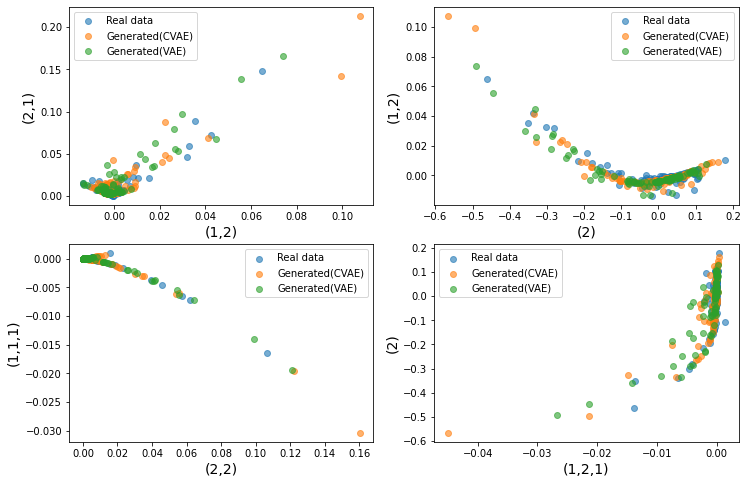

In [25]:
from esig.tosig import sigkeys

keys = sigkeys(2, order).split()

factor = []
for i in keys:
    factor.append((np.ceil((len(i)-2)/2)))
factor = np.array(factor)

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)

    plt.scatter(test_sig[:, projection[0]], test_sig[:, projection[1]],
                label="Real data", alpha = 0.6)
    plt.scatter(generated_sigs[:, projection[0]], generated_sigs[:, projection[1]],
               label="Generated(CVAE)", alpha = 0.6)
    plt.scatter(generated_sigs2[:, projection[0]], generated_sigs2[:, projection[1]],
               label="Generated(VAE)", alpha = 0.6)
    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
#     plt.xticks([])
#     plt.yticks([])
    plt.legend()
    
plt.show()

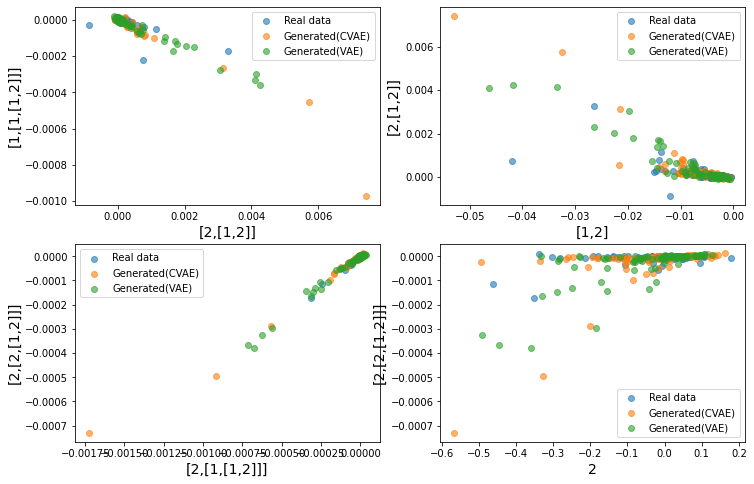

In [26]:
from esig.tosig import logsigkeys
import re

logkeys = logsigkeys(2, order).split()

logfactor = []
for i in logkeys:
    logfactor.append((len(re.sub("\D", "", i))))
logfactor = np.array(logfactor)

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (1, 7)]

x = plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i+1)

    plt.scatter(test_logsig[:, projection[0]], test_logsig[:, projection[1]],
                label="Real data", alpha=0.6)
    plt.scatter(generated[:, projection[0]], generated[:, projection[1]],
               label="Generated(CVAE)", alpha=0.6)
    plt.scatter(generated2[:, projection[0]], generated2[:, projection[1]],
               label="Generated(VAE)", alpha=0.6)
    plt.xlabel(logkeys[projection[0]], fontsize=14)
    plt.ylabel(logkeys[projection[1]], fontsize=14)
#     plt.xticks([])
#     plt.yticks([])
    plt.legend()
plt.show()

## Evaluation

In [27]:
import evaluation
reload(evaluation)

import process_discriminator
reload(process_discriminator)

<module 'process_discriminator' from '../src\\process_discriminator.py'>

In [28]:
windows_test = _load_rough_bergomi(params)
test_sig = np.array([_sig(path) for path in tqdm(windows_test, desc="Computing signatures")])

normalised_generated = np.array([generator.generate(cond)[0] for cond in conditions])
generated = scaler.inverse_transform(normalised_generated)
generated_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated)])
# real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(orig_logsig)])

normalised_generated2 = np.array([generator2.generate()[0] for i in range(len(logsig))])
generated2 = scaler.inverse_transform(normalised_generated2)
generated_sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated2)])
# real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(orig_logsig)])

phi1 = process_discriminator.T_global(test_sig, generated_sigs2,\
                                     order=4, verbose=False, normalise=True, compute_sigs=False)
phi2 = process_discriminator.T_global(test_sig[1:], generated_sigs,\
                                     order=4, verbose=False, normalise=True, compute_sigs=False)
phi = min(phi1,phi2)


0.9999999999902702
0.9999999999902702


In [31]:
TU_VAE = []
TU_CVAE = []
for i in range(50):
    windows_test = _load_rough_bergomi(params)
    test_sig = np.array([_sig(path) for path in tqdm(windows_test, desc="Computing signatures")])

    normalised_generated = np.array([generator.generate(cond)[0] for cond in conditions])
    generated = scaler.inverse_transform(normalised_generated)
    generated_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated)])
    # real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(orig_logsig)])

    normalised_generated2 = np.array([generator2.generate()[0] for i in range(len(logsig))])
    generated2 = scaler.inverse_transform(normalised_generated2)
    generated_sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated2)])
    # real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(orig_logsig)])
    
    result, TU = process_discriminator.test_fix(test_sig[1:], generated_sigs2[1:],\
                                                order=order, confidence_level=0.99, phi_x = phi, compute_sigs=False)
    TU_VAE.append(TU)
    result, TU = process_discriminator.test_fix(test_sig[1:], generated_sigs,\
                                                order=order, confidence_level=0.99, phi_x = phi, compute_sigs=False)
    TU_CVAE.append(TU)


0.9999999999902702
c: 0.04030256447915187
TU: 0.01230162596085349
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0013453512258556621
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0045259459054252105
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0008593519940078842
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.005321865916178226
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0023559806992397014
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.007543452980714571
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0054663390724465355
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.005499231003458505
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0024961551421700534
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.01713408384569015
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.00924708330081958
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.008944914229448875
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.002489947699811923
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.012747558361877465
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.00501468081983325
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.01031997866138279
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.003742634759065444
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.008919459343263103
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.004592983306576315
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.007109472705205899
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0005833156167556197
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0064055833630281
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0010693817075912992
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.009878525075597278
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.001504616978228679
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.012802566179556552
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.006246033696183817
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.004662472555588604
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 4.873988921794137e-06
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0027993644752641877
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0003281012441247455
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.009833050625755346
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.006008452889806115
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.005867511247279467
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0016500972165924832
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.019512132606243293
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.005184943363297556
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.011783651899129666
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.008753006449223832
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.012433983172035479
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0020016492967203092
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.01110648837836603
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.004069113401584001
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.01169464063702974
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.005302433125709438
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.014672269815641403
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0012508264834876215
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.007480969942859961
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.001907232981980922
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.004166704346787675
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0012310497214360616
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.007440995371199133
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 7.725721022655563e-05
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.014908355363704384
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0036638265247139756
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.007046281218108019
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0005358976122868953
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.005692438526443411
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0010952590259716288
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.003924078741686099
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0003172879516322169
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.005716895499661145
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.007460471478645481
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.009891443675752232
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.002151437627463615
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.007256461923415447
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.007716362368013208
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.012732587884505264
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.00478936656905371
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.003830459550753229
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0020709666219418388
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.011432237760144126
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.00470604338003433
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.009806901942341906
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.001215490419121501
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.00935498213538466
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.003970943473490696
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.025511206541947384
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.005739499857225772
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.010276327769552118
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.007923390303707478
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.012365090395293876
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.003556957106957359
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.002325825922446345
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0003024875939203753
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.002987548296554454
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0002841978606804574
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.005024431987149747
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0010910317474044362
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0070121252770514175
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.002348229994160622
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0003425282731792656
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.000466900393832681
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.01326233958546763
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.002842462251149369
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.014054881432056021
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0027208153565649873
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.012668001153683495
m: 99



0.9999999999902702
c: 0.04030256447915187
TU: 0.0015552856012752692
m: 99


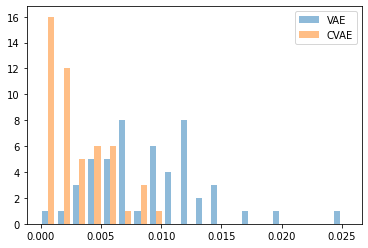

In [32]:
plt.hist(np.array([TU_VAE,TU_CVAE]).T, bins = 20, alpha = 0.5)
plt.legend(['VAE','CVAE'])
plt.show()

## From Signature to Path

In [9]:
import logsig_inversion
from esig.tosig import stream2logsig
from utils.leadlag import leadlag
from gpsig import kernels
import gpflow

In [10]:
pip = 0.001
n_pips = 5 * 10
n_points = 28
n_iterations = 100
n_organisms = 100
recovered_paths = []
for i, logsig in enumerate(generated):
    recovered_paths.append(logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points, pip, n_pips)[0] + 1.)
    

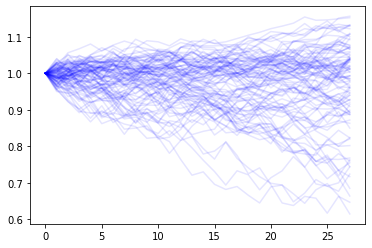

In [15]:
plt.plot(np.array(recovered_paths).T, "b", alpha=0.1)
plt.show()